In [15]:
#!/home/was966/micromamba/envs/responder/bin/python
#sbatch --mem 64G -c 4 -t 12:00:00 -p gpu_quad --gres=gpu:rtx8000:1 ./01_cohort_to_cohort_transfer.py

import sys

sys.path.insert(0, '/home/was966/Research/mims-conceptor/')
from conceptor.utils import plot_embed_with_label
from conceptor import PreTrainer, FineTuner, loadconceptor #, get_minmal_epoch
from conceptor.utils import plot_embed_with_label, score2
from conceptor.tokenizer import CANCER_CODE

import os
from tqdm import tqdm
from itertools import chain
import pandas as pd
import numpy as np
import random, torch
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'white', font_scale=1.3)
import warnings
warnings.filterwarnings("ignore")

def onehot(S):
    assert type(S) == pd.Series, 'Input type should be pd.Series'
    dfd = pd.get_dummies(S, dummy_na=True)
    nanidx = dfd[dfd[np.nan].astype(bool)].index
    dfd.loc[nanidx, :] = np.nan
    dfd = dfd.drop(columns=[np.nan])*1.
    cols = dfd.sum().sort_values(ascending=False).index.tolist()
    dfd = dfd[cols]
    return dfd

def random_acc(R, NR):
    positive_samples = R
    negative_samples = NR
    total_samples = positive_samples + negative_samples
    
    # For random guessing, the probability of guessing a sample correctly is:
    # (probability of guessing a positive correctly + probability of guessing a negative correctly) / total possibilities
    
    # The probability of guessing a positive sample correctly is the proportion of positive samples,
    # and similarly for negative samples.
    
    random_guess_accuracy = (positive_samples/total_samples * positive_samples/total_samples) + \
                            (negative_samples/total_samples * negative_samples/total_samples)
    return random_guess_accuracy


In [16]:
df_c2c = pd.read_csv('./stratification/cancer2cancer.csv', index_col=0)
df_d2d = pd.read_csv('./stratification/drug2drug.csv', index_col=0)
df_s2s = pd.read_csv('./stratification/sequencer2sequencer.csv', index_col=0)

df_label = pd.concat([df_c2c, df_d2d, df_s2s])
cohorts = df_label['stratified_cohort'].unique().tolist()

In [17]:
from glob import glob

In [18]:
csvs = glob('./*/F2F/*/metric_performance.tsv')

In [19]:
res = []
for csv in csvs:
    df = pd.read_csv(csv, sep='\t', index_col=0)
    res.append(df)

In [20]:
df = pd.concat(res)
df['transfer'] = df.train_cohort + '-to-' + df.test_cohort

In [21]:
cancer_domain = ['Atezo_HiSeq2500_BLCA',
  'Atezo_HiSeq2500_KIRC',
  'Nivo_HiSeq2000_GBM',
  'Nivo_HiSeq2000_KIRC',
  'Nivo_HiSeq2500_LUAD',
  'Nivo_HiSeq2500_SKCM',
  'Pembro_HiSeq2500_LUAD',
  'Pembro_HiSeq2500_SKCM',
  'Pembro_HiSeq2500_STAD']

drug_domain = ['BLCA_NovaSeq6000_Atezo',
  'BLCA_NovaSeq6000_Pembro',
  'LUAD_HiSeq2500_Nivo',
  'LUAD_HiSeq2500_Pembro',
  'SKCM_HiSeq2500_Ipi',
  'SKCM_HiSeq2500_Nivo',
  'SKCM_HiSeq2500_Pembro']

sequencer_domain =['BLCA_Atezo_HiSeq2500',
  'BLCA_Atezo_HiSeq4000',
  'BLCA_Atezo_NovaSeq6000',
  'SKCM_Nivo_HiSeq2000/2500',
  'SKCM_Nivo_HiSeq2500',
  'SKCM_Pembro_HiSeq2000',
  'SKCM_Pembro_HiSeq2500']

In [22]:
train_cohorts = drug_domain 
test_cohorts = drug_domain

## Merge & analysis

In [23]:
data = df.reset_index(drop=True)
data.head()

,domain,group,train_cohort,test_cohort,mode,best_C,test_cohort_rgc,ROC,PRC,F1,ACC,MCC,best_epoch,transfer
0,cancer2cancer,Atezo_HiSeq2500,Atezo_HiSeq2500_BLCA,Atezo_HiSeq2500_KIRC,CAF,0.1,0.587438,0.581375,0.333563,0.455285,0.593939,0.165667,NaN,Atezo_HiSeq2500_BLCA-to-Atezo_HiSeq2500_KIRC
1,cancer2cancer,Atezo_HiSeq2500,Atezo_HiSeq2500_KIRC,Atezo_HiSeq2500_BLCA,CAF,0.1,0.647764,0.551854,0.244666,0.388626,0.567114,0.133950,NaN,Atezo_HiSeq2500_KIRC-to-Atezo_HiSeq2500_BLCA
2,cancer2cancer,Nivo_HiSeq2000,Nivo_HiSeq2000_GBM,Nivo_HiSeq2000_KIRC,CAF,0.1,0.755102,0.648148,0.448347,0.333333,0.619048,0.196419,NaN,Nivo_HiSeq2000_GBM-to-Nivo_HiSeq2000_KIRC
3,cancer2cancer,Nivo_HiSeq2000,Nivo_HiSeq2000_KIRC,Nivo_HiSeq2000_GBM,CAF,0.1,0.580000,0.559524,0.431157,0.428571,0.600000,0.133631,NaN,Nivo_HiSeq2000_KIRC-to-Nivo_HiSeq2000_GBM
4,cancer2cancer,Nivo_HiSeq2500,Nivo_HiSeq2500_LUAD,Nivo_HiSeq2500_SKCM,CAF,0.1,0.524691,0.327561,0.330770,0.352941,0.388889,-0.203859,NaN,Nivo_HiSeq2500_LUAD-to-Nivo_HiSeq2500_SKCM


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

drug2drug vs. sequencer2sequencer: Mann-Whitney-Wilcoxon test two-sided, P_val:3.009e-04 U_stat=5.360e+02
cancer2cancer vs. drug2drug: Mann-Whitney-Wilcoxon test two-sided, P_val:5.643e-01 U_stat=3.700e+02
cancer2cancer vs. sequencer2sequencer: Mann-Whitney-Wilcoxon test two-sided, P_val:7.340e-04 U_stat=5.230e+02
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

drug2drug vs. sequencer2sequencer: Mann-Whitney-Wilcoxon test two-sided, P_val:4.558e-03 U_stat=4.935e+02
cancer2cancer vs. drug2drug: Mann-Whitney-Wilcoxon test two-sided, P_val:5.465e-02 U_stat=4.435e+02
cancer2cancer vs. sequencer2sequencer: Mann-Whitney-Wilcoxon test two-sided, P_val:3.229e-04 U

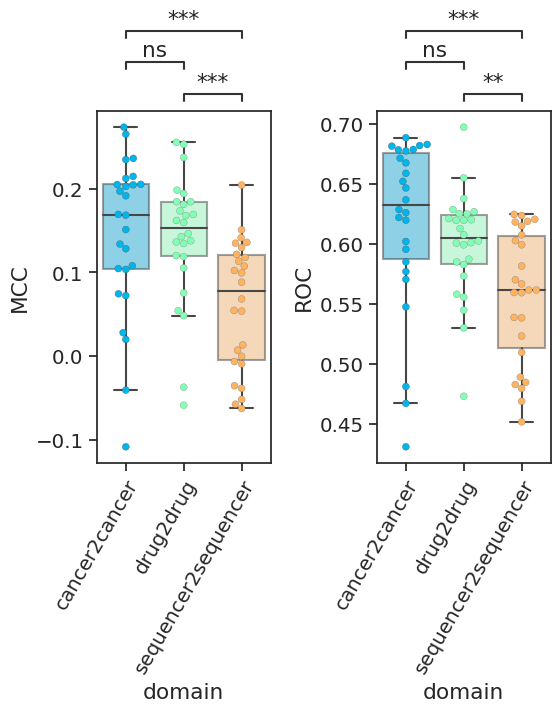

In [24]:
import scipy
from statannotations.Annotator import Annotator
fig, (ax1, ax2) = plt.subplots(figsize=(6, 8), ncols=2, sharex=False, sharey=False)

box_pairs = [('sequencer2sequencer', 'drug2drug'),
             ('cancer2cancer', 'sequencer2sequencer'), 
             ('cancer2cancer', 'drug2drug')]

dfd = data.groupby(['domain', 'mode']).MCC.median().unstack().T
x_order = dfd.mean(axis=0).sort_values(ascending=False).index.tolist()
y_order = dfd.mean(axis=1).sort_values().index
datap = dfd.loc[y_order].T
datap = datap.unstack().reset_index()


sns.boxplot(datap, x='domain',  order = x_order, y = 0,   ax=ax1,  fliersize=0, palette='rainbow',  
            boxprops={'alpha':0.5})
sns.swarmplot(datap, x='domain', y = 0,   ax=ax1, palette='rainbow', linewidth = 0.2, order=x_order)

annotator = Annotator(ax1, pairs=box_pairs, data=datap, x='domain', y=0, order=x_order)
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside', comparisons_correction = None,)
annotator.apply_and_annotate()

ax1.set_ylabel('MCC')
ax1.tick_params(axis='both', which='major', right = False, top=False, direction = 'out',reset = True)

ax1.set_xticklabels(x_order, 
                    rotation=60, 
                    ha="right",  
                    rotation_mode="anchor")  # <====== HERE is the ke


#====================================================================================
dfd = data.groupby(['domain', 'mode']).ROC.median().unstack().T
y_order = dfd.mean(axis=1).sort_values().index
datap = dfd.loc[y_order].T
datap = datap.unstack().reset_index()


sns.boxplot(datap, x='domain', y = 0,  order = x_order,  ax=ax2,  fliersize=0, palette='rainbow',  
            boxprops={'alpha':0.5})
sns.swarmplot(datap, x='domain', y = 0,   ax=ax2, palette='rainbow', linewidth = 0.2)

annotator = Annotator(ax2, pairs=box_pairs, data=datap, x='domain', y=0, order=x_order)
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside', comparisons_correction = None,)
annotator.apply_and_annotate()


ax2.set_ylabel('ROC')
ax2.tick_params(axis='both', which='major', right = False, top=False, direction = 'out',reset = True)

ax2.set_xticklabels(x_order, 
                    rotation=60, 
                    ha="right",  
                    rotation_mode="anchor")  # <====== HERE is the ke

fig.tight_layout()
fig.savefig('./domain_transfer_comparasions.pdf', bbox_inches='tight')

In [25]:
colors = sns.color_palette('PiYG', 10)
mt_color = colors[-2]
nt_color = colors[1]
colors

[(0.7514033064206075, 0.09588619761630142, 0.4736639753940792),
 (0.8513648596693579, 0.395924644367551, 0.6446751249519416),
 (0.9231833910034601, 0.6410611303344866, 0.804152249134948),
 (0.9755478662053056, 0.8202998846597462, 0.9081891580161476),
 (0.9792387543252595, 0.9279507881584006, 0.954479046520569),
 (0.938562091503268, 0.9650903498654364, 0.8996539792387543),
 (0.8382929642445216, 0.9331026528258363, 0.7132641291810845),
 (0.6558246828143024, 0.8396770472895041, 0.4459054209919264),
 (0.4595924644367551, 0.7049596309111881, 0.23029603998462128),
 (0.2873510188389081, 0.5548635140330642, 0.1263360246059208)]

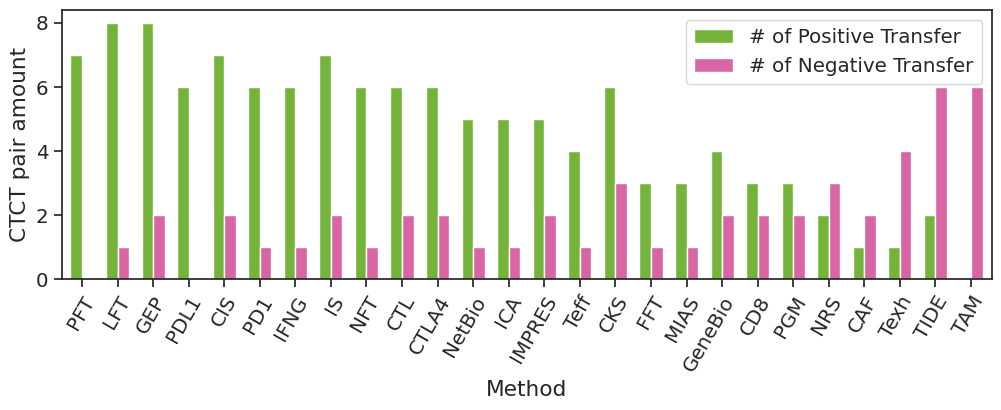

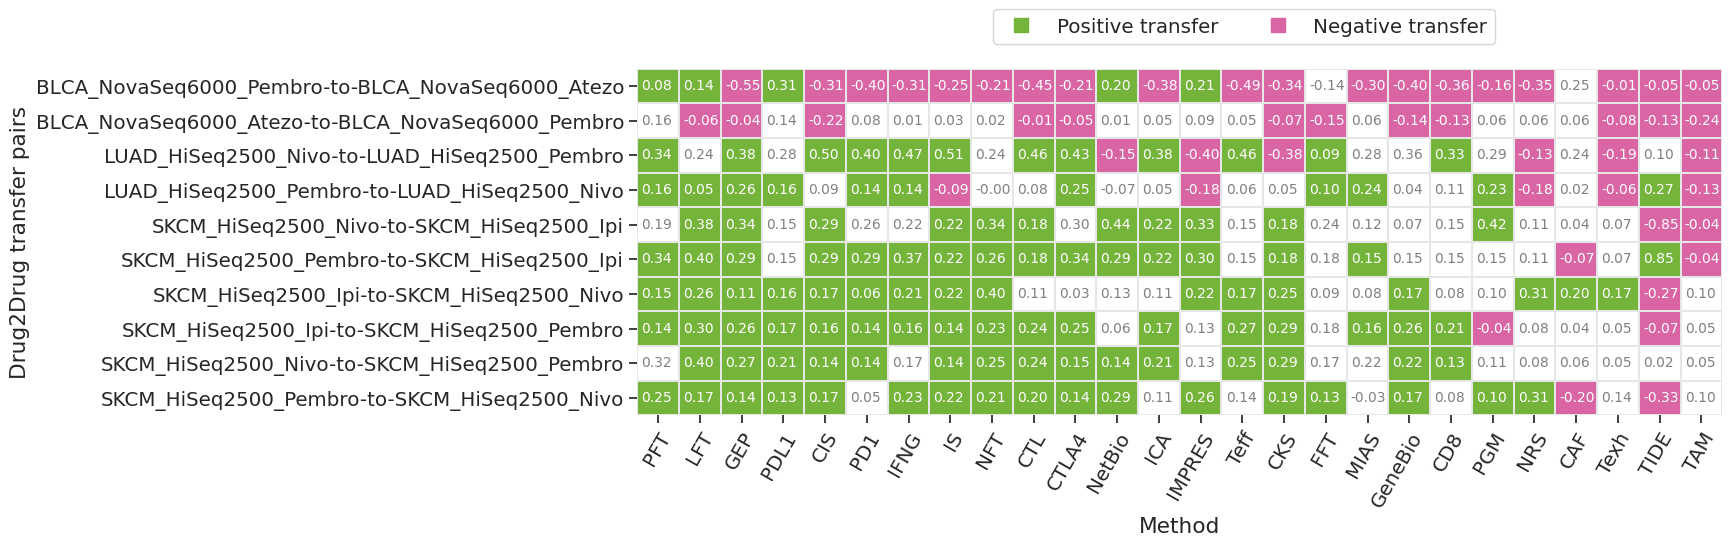

In [26]:
datas = data[data.train_cohort.isin(drug_domain) & data.test_cohort.isin(drug_domain)]
data_mt = datas[(datas.ACC > datas.test_cohort_rgc + 0.05) & (datas.MCC > 0)]
df_mt = data_mt.groupby('mode').size().to_frame('# of Positive Transfer')

data_nt = datas[(datas.ACC < datas.test_cohort_rgc) & (datas.MCC < 0)]
df_nt = data_nt.groupby('mode').size().to_frame('# of Negative Transfer')

datas['positive_transfer'] = datas.index.isin(data_mt.index)
datas['negative_transfer'] = datas.index.isin(data_nt.index)

dft = pd.DataFrame([],index=datas['mode'].unique()).join(df_mt).join(df_nt).fillna(0)

fig, ax = plt.subplots(figsize=(12, 3.5),  )

x_order = (dft[dft.columns[1]] - dft[dft.columns[0]]).sort_values().index
#x_order = (dft[dft.columns[0]]).sort_values().index

dft = dft.loc[x_order]

dft.plot(kind='bar', ax=ax, color= [mt_color, nt_color], alpha = 1, width=0.65)
ax.set_ylabel('CTCT pair amount')

ax.tick_params(axis='both', which='major', right = False, top=False, direction = 'out',reset = True)
# # #fig.savefig('./avg_refined_distribution.pdf')
ax.set_xticklabels(
    x_order, 
    rotation=60, 
    ha="right",  
    rotation_mode="anchor")  # <====== HERE is the ke

ax.set_xlabel('Method')

fig.savefig('./drug2drug_bar.pdf', bbox_inches='tight')

# =================================================================================================

dfb1 = pd.pivot_table(datas, columns = 'mode', index='transfer', values = 'positive_transfer' )
dfb1 = pd.DataFrame(np.where(dfb1 !=0, dfb1, np.nan), index=dfb1.index, columns= dfb1.columns)

dfb2 = pd.pivot_table(datas, columns = 'mode', index='transfer', values = 'negative_transfer' )
dfb2 = pd.DataFrame(np.where(dfb2 !=0, dfb2, np.nan), index=dfb2.index, columns= dfb2.columns)

y_order = (dfb1.sum(axis=1) - dfb2.sum(axis=1)).sort_values().index

# x_order = dfb1.sum().sort_values().index
# y_order = dfb1.sum(axis=1).sort_values().index

dfb1 = dfb1[x_order].loc[y_order]
dfb2 = dfb2[x_order].loc[y_order]

fig, ax = plt.subplots(figsize=(14, 4.5))
# sns.heatmap(dfb1, cmap = 'Greens', ax=ax, linewidths = 0.01)
cmap1 = sns.light_palette(mt_color, n_colors =  2, reverse=True)
cmap2 = sns.light_palette(nt_color, n_colors =  2, reverse=True)

sns.heatmap(dfb1, 
        cmap = cmap1, ax = ax, #vmax = data.max()-0.01,
        cbar=False,  #cbar_kws = dict(use_gridspec=False,location="bottom"), 
        linewidths=0.003, linecolor = '0.9')#

sns.heatmap(dfb2, 
        cmap = cmap2, ax = ax, #vmax = data.max()-0.01,
        cbar=False,  #cbar_kws = dict(use_gridspec=False,location="bottom"), 
        linewidths=0.003, linecolor = '0.9')#

x_axis_dict = {}
for i in ax.xaxis.get_ticklabels():
    p = i.get_position()
    k = i.get_text()
    x_axis_dict[k] = p
    
y_axis_dict = {}
for i in ax.yaxis.get_ticklabels():
    p = i.get_position()
    k = i.get_text()
    y_axis_dict[k] = p
    
    
for i in range(len(datas)):
    ts = datas.iloc[i]
    v = '%.2f' % ts.MCC
    x = ts['mode']
    y = ts.transfer
    x = x_axis_dict[x][0]-0.4
    y = y_axis_dict[y][1] + 0.1
    
    if ts.positive_transfer | ts.negative_transfer:
        color = 'white'
    else:
        color = 'gray'
    ax.text(x, y, v, fontdict={'fontsize':10, 'color':color})


ax.tick_params(axis='both', which='major', right = False, top=False, direction = 'out',reset = True)
ax.set_xticklabels(x_order, 
                    rotation=60, 
                    ha="right",  
                    rotation_mode="anchor")  # <====== HERE is the ke
ax.set_ylabel('Drug2Drug transfer pairs')
ax.set_xlabel('Method')

l1 = plt.plot([],[], marker="s", ms=10, ls="", mec=None, color=cmap1[0], label= 'Positive transfer' )[0]
l2 = plt.plot([],[], marker="s", ms=10, ls="", mec=None, color=cmap2[0], label= 'Negative transfer' )[0]
#l3 = plt.plot([],[], marker="s", ms=10, ls="", mec=None, color=cmap2[1], label= 'Ambigorious' )[0]

patches = [l1, l2,] # l3
ax.legend(handles=patches, bbox_to_anchor=(0.80,1.2),  
          loc='upper right', ncol=3, facecolor="w", numpoints=1, ) 
fig.savefig('./drug2drug_heatmap.pdf', bbox_inches='tight')

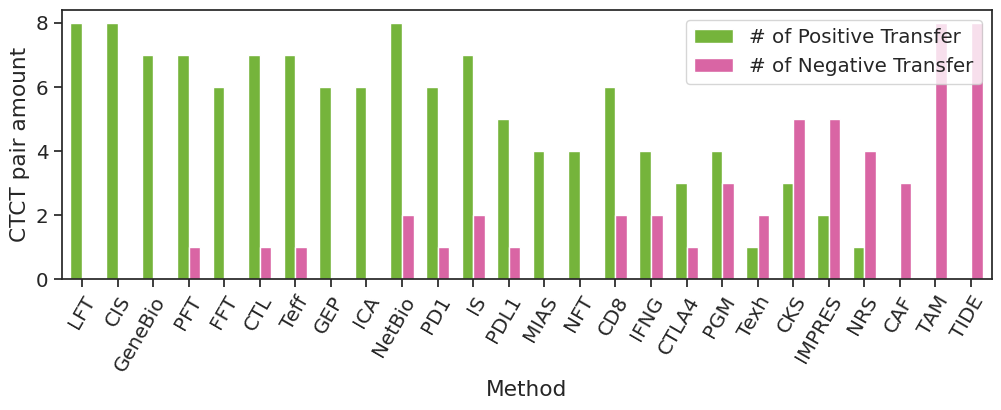

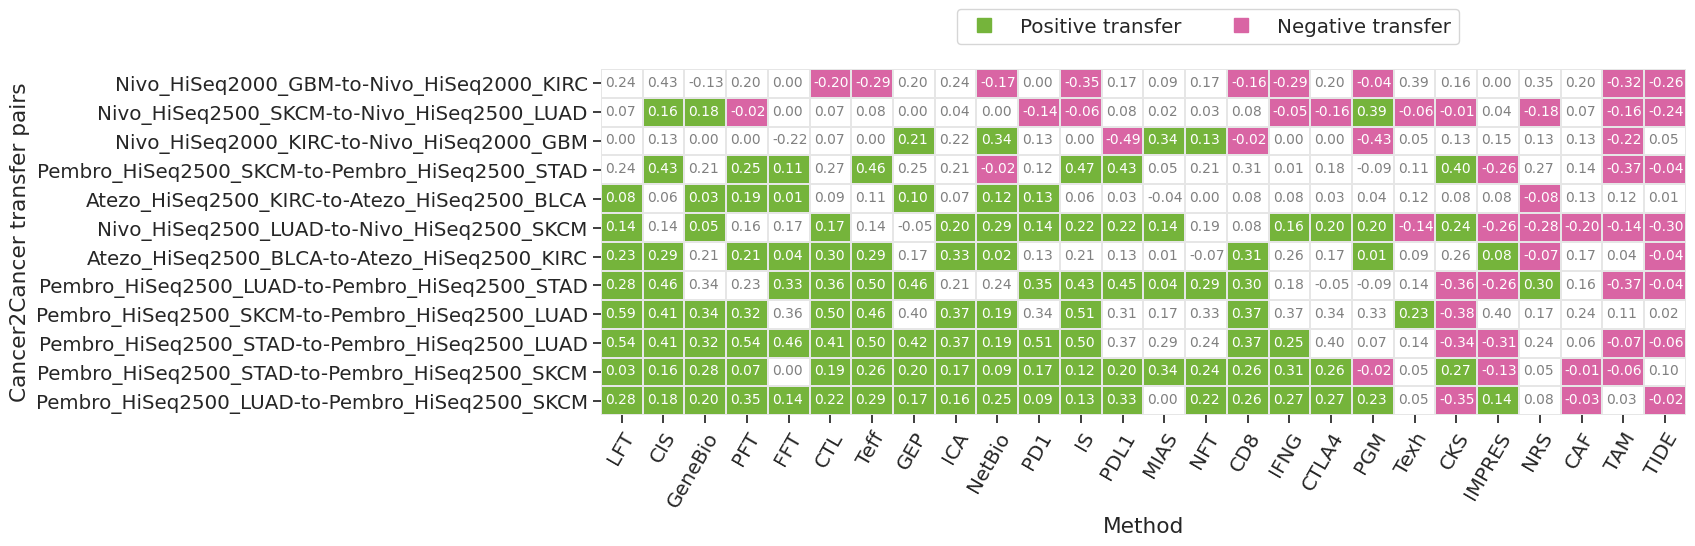

In [27]:
datas = data[data.train_cohort.isin(cancer_domain) & data.test_cohort.isin(cancer_domain)]
data_mt = datas[(datas.ACC > datas.test_cohort_rgc + 0.05) & (datas.MCC > 0)]
df_mt = data_mt.groupby('mode').size().to_frame('# of Positive Transfer')

data_nt = datas[(datas.ACC < datas.test_cohort_rgc) & (datas.MCC < 0)]
df_nt = data_nt.groupby('mode').size().to_frame('# of Negative Transfer')

datas['positive_transfer'] = datas.index.isin(data_mt.index)
datas['negative_transfer'] = datas.index.isin(data_nt.index)

dft = pd.DataFrame([],index=datas['mode'].unique()).join(df_mt).join(df_nt).fillna(0)

fig, ax = plt.subplots(figsize=(12, 3.5),  )

x_order = (dft[dft.columns[1]] - dft[dft.columns[0]]).sort_values().index
#x_order = (dft[dft.columns[0]]).sort_values().index

dft = dft.loc[x_order]

dft.plot(kind='bar', ax=ax, color= [mt_color, nt_color], alpha = 1, width=0.65)
ax.set_ylabel('CTCT pair amount')

ax.tick_params(axis='both', which='major', right = False, top=False, direction = 'out',reset = True)
# # #fig.savefig('./avg_refined_distribution.pdf')
ax.set_xticklabels(
    x_order, 
    rotation=60, 
    ha="right",  
    rotation_mode="anchor")  # <====== HERE is the ke

ax.set_xlabel('Method')

fig.savefig('./cancer2cancer_bar.pdf', bbox_inches='tight')

# =================================================================================================

dfb1 = pd.pivot_table(datas, columns = 'mode', index='transfer', values = 'positive_transfer' )
dfb1 = pd.DataFrame(np.where(dfb1 !=0, dfb1, np.nan), index=dfb1.index, columns= dfb1.columns)

dfb2 = pd.pivot_table(datas, columns = 'mode', index='transfer', values = 'negative_transfer' )
dfb2 = pd.DataFrame(np.where(dfb2 !=0, dfb2, np.nan), index=dfb2.index, columns= dfb2.columns)

#x_order = (dfb1.sum() - dfb2.sum()).sort_values().index
y_order = (dfb1.sum(axis=1) - dfb2.sum(axis=1)).sort_values().index

# x_order = dfb1.sum().sort_values().index
# y_order = dfb1.sum(axis=1).sort_values().index

dfb1 = dfb1[x_order].loc[y_order]
dfb2 = dfb2[x_order].loc[y_order]

fig, ax = plt.subplots(figsize=(14, 4.5))
# sns.heatmap(dfb1, cmap = 'Greens', ax=ax, linewidths = 0.01)
cmap1 = sns.light_palette(mt_color, n_colors =  2, reverse=True)
cmap2 = sns.light_palette(nt_color, n_colors =  2, reverse=True)

sns.heatmap(dfb1, 
        cmap = cmap1, ax = ax, #vmax = data.max()-0.01,
        cbar=False,  #cbar_kws = dict(use_gridspec=False,location="bottom"), 
        linewidths=0.003, linecolor = '0.9')#

sns.heatmap(dfb2, 
        cmap = cmap2, ax = ax, #vmax = data.max()-0.01,
        cbar=False,  #cbar_kws = dict(use_gridspec=False,location="bottom"), 
        linewidths=0.003, linecolor = '0.9')#

x_axis_dict = {}
for i in ax.xaxis.get_ticklabels():
    p = i.get_position()
    k = i.get_text()
    x_axis_dict[k] = p

y_axis_dict = {}
for i in ax.yaxis.get_ticklabels():
    p = i.get_position()
    k = i.get_text()
    y_axis_dict[k] = p
    
    
for i in range(len(datas)):
    ts = datas.iloc[i]
    v = '%.2f' % ts.MCC
    x = ts['mode']
    y = ts.transfer
    x = x_axis_dict[x][0]-0.4
    y = y_axis_dict[y][1] + 0.1
    
    if ts.positive_transfer | ts.negative_transfer:
        color = 'white'
    else:
        color = 'gray'
    ax.text(x, y, v, fontdict={'fontsize':10, 'color':color})



ax.tick_params(axis='both', which='major', right = False, top=False, direction = 'out',reset = True)
ax.set_xticklabels(x_order, 
                    rotation=60, 
                    ha="right",  
                    rotation_mode="anchor")  # <====== HERE is the ke
ax.set_ylabel('Cancer2Cancer transfer pairs')
ax.set_xlabel('Method')

l1 = plt.plot([],[], marker="s", ms=10, ls="", mec=None, color=cmap1[0], label= 'Positive transfer' )[0]
l2 = plt.plot([],[], marker="s", ms=10, ls="", mec=None, color=cmap2[0], label= 'Negative transfer' )[0]
#l3 = plt.plot([],[], marker="s", ms=10, ls="", mec=None, color=cmap2[1], label= 'Ambigorious' )[0]

patches = [l1, l2,] # l3
ax.legend(handles=patches, bbox_to_anchor=(0.80,1.2),  
          loc='upper right', ncol=3, facecolor="w", numpoints=1, ) 
fig.savefig('./cancer2cancer_heatmap.pdf', bbox_inches='tight')

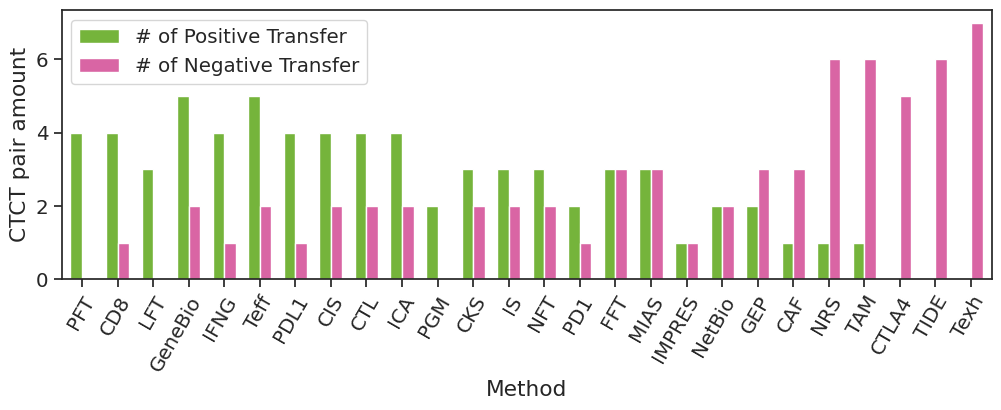

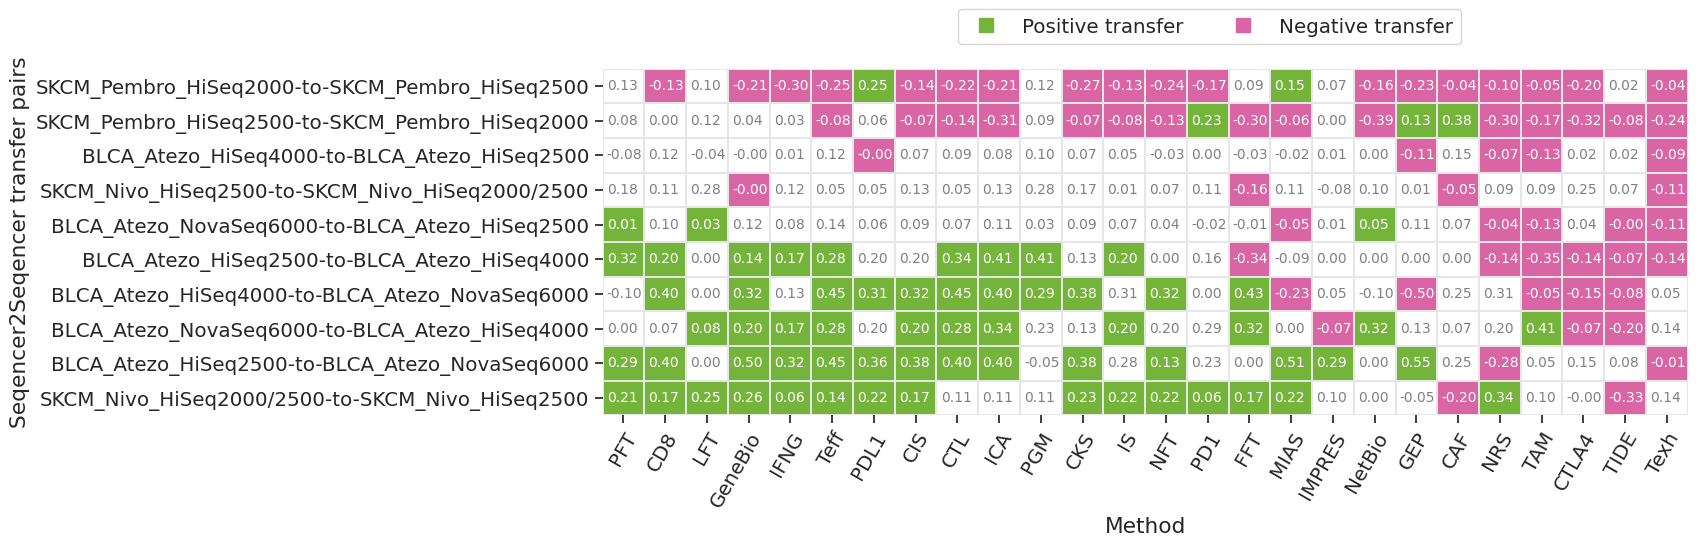

In [28]:
datas = data[data.train_cohort.isin(sequencer_domain) & data.test_cohort.isin(sequencer_domain)]
data_mt = datas[(datas.ACC > datas.test_cohort_rgc + 0.05) & (datas.MCC > 0)]
df_mt = data_mt.groupby('mode').size().to_frame('# of Positive Transfer')

data_nt = datas[(datas.ACC < datas.test_cohort_rgc) & (datas.MCC < 0)]
df_nt = data_nt.groupby('mode').size().to_frame('# of Negative Transfer')

datas['positive_transfer'] = datas.index.isin(data_mt.index)
datas['negative_transfer'] = datas.index.isin(data_nt.index)

dft = pd.DataFrame([],index=datas['mode'].unique()).join(df_mt).join(df_nt).fillna(0)

fig, ax = plt.subplots(figsize=(12, 3.5),  )

x_order = (dft[dft.columns[1]] - dft[dft.columns[0]]).sort_values().index
#x_order = (dft[dft.columns[0]]).sort_values(ascending=False).index

dft = dft.loc[x_order]

dft.plot(kind='bar', ax=ax, color= [mt_color, nt_color], alpha = 1, width=0.65)
ax.set_ylabel('CTCT pair amount')

ax.tick_params(axis='both', which='major', right = False, top=False, direction = 'out',reset = True)
# # #fig.savefig('./avg_refined_distribution.pdf')
ax.set_xticklabels(
    x_order, 
    rotation=60, 
    ha="right",  
    rotation_mode="anchor")  # <====== HERE is the ke

ax.set_xlabel('Method')

fig.savefig('./seqencer2seqencer_bar.pdf', bbox_inches='tight')

# =================================================================================================

dfb1 = pd.pivot_table(datas, columns = 'mode', index='transfer', values = 'positive_transfer' )
dfb1 = pd.DataFrame(np.where(dfb1 !=0, dfb1, np.nan), index=dfb1.index, columns= dfb1.columns)

dfb2 = pd.pivot_table(datas, columns = 'mode', index='transfer', values = 'negative_transfer' )
dfb2 = pd.DataFrame(np.where(dfb2 !=0, dfb2, np.nan), index=dfb2.index, columns= dfb2.columns)

#x_order = (dfb1.sum() - dfb2.sum()).sort_values().index
y_order = (dfb1.sum(axis=1) - dfb2.sum(axis=1)).sort_values().index

# x_order = dfb1.sum().sort_values().index
# y_order = dfb1.sum(axis=1).sort_values().index

dfb1 = dfb1[x_order].loc[y_order]
dfb2 = dfb2[x_order].loc[y_order]

fig, ax = plt.subplots(figsize=(14, 4.5))
# sns.heatmap(dfb1, cmap = 'Greens', ax=ax, linewidths = 0.01)
cmap1 = sns.light_palette(mt_color, n_colors =  2, reverse=True)
cmap2 = sns.light_palette(nt_color, n_colors =  2, reverse=True)

sns.heatmap(dfb1, 
        cmap = cmap1, ax = ax, #vmax = data.max()-0.01,
        cbar=False,  #cbar_kws = dict(use_gridspec=False,location="bottom"), 
        linewidths=0.003, linecolor = '0.9')#

sns.heatmap(dfb2, 
        cmap = cmap2, ax = ax, #vmax = data.max()-0.01,
        cbar=False,  #cbar_kws = dict(use_gridspec=False,location="bottom"), 
        linewidths=0.003, linecolor = '0.9')#

x_axis_dict = {}
for i in ax.xaxis.get_ticklabels():
    p = i.get_position()
    k = i.get_text()
    x_axis_dict[k] = p
    
y_axis_dict = {}
for i in ax.yaxis.get_ticklabels():
    p = i.get_position()
    k = i.get_text()
    y_axis_dict[k] = p
    
    
for i in range(len(datas)):
    ts = datas.iloc[i]
    v = '%.2f' % ts.MCC
    x = ts['mode']
    y = ts.transfer
    x = x_axis_dict[x][0]-0.4
    y = y_axis_dict[y][1] + 0.1
    
    if ts.positive_transfer | ts.negative_transfer:
        color = 'white'
    else:
        color = 'gray'
    ax.text(x, y, v, fontdict={'fontsize':10, 'color':color})



ax.tick_params(axis='both', which='major', right = False, top=False, direction = 'out',reset = True)
ax.set_xticklabels(x_order, 
                    rotation=60, 
                    ha="right",  
                    rotation_mode="anchor")  # <====== HERE is the ke
ax.set_ylabel('Seqencer2Seqencer transfer pairs')
ax.set_xlabel('Method')

l1 = plt.plot([],[], marker="s", ms=10, ls="", mec=None, color=cmap1[0], label= 'Positive transfer' )[0]
l2 = plt.plot([],[], marker="s", ms=10, ls="", mec=None, color=cmap2[0], label= 'Negative transfer' )[0]
#l3 = plt.plot([],[], marker="s", ms=10, ls="", mec=None, color=cmap2[1], label= 'Ambigorious' )[0]

patches = [l1, l2,] # l3
ax.legend(handles=patches, bbox_to_anchor=(0.80,1.2),  
          loc='upper right', ncol=3, facecolor="w", numpoints=1, ) 


fig.savefig('./seqencer2seqencer_heatmap.pdf', bbox_inches='tight')